In [1]:
import tifffile as tiff #for read multi chanel img
import random
from collections import deque
import tensorflow as tf
from tensorflow import keras
#import cv2
import matplotlib.pyplot as plt
from collections import deque
from PIL import Image
import numpy as np
import rasterio as rio
#from pyrsgis import ml
import csv
import pandas as pd
from sklearn.model_selection import train_test_split


In [9]:
# Load ip/rs data

file_path = 'D:/GeoPhy_2/IP/Scenario14/LocIPALL_Sc14.xlsx'
#file_path = 'D:/GeoPhy/point/second_local/PAll_Clean.xlsx'
data_ip = pd.read_excel(file_path)

# Define high potential condition
#high_condition = (data_ip['RS'].between(1, 100)) & (data_ip['IP'].between(12, 300))& (data_ip['pname']!="P5")

high_condition = (data_ip['Res'].between(5,100)) & (data_ip['IP'].between(12, 4018)) #& (data_ip['Name']!="P1")

# Create a new column for classification
data_ip['Potential'] = [1 if cond else 0 for cond in high_condition]

print(data_ip[data_ip['Potential']==1].shape,data_ip.shape)

(381, 7) (2549, 7)


In [5]:
print(data_ip["X"])

0       772281
1       772301
2       772321
3       772341
4       772361
         ...  
1624    772888
1625    772908
1626    772928
1627    772948
1628    772968
Name: X, Length: 1629, dtype: int64


In [11]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10

In [13]:
from mpl_toolkits.mplot3d import Axes3D

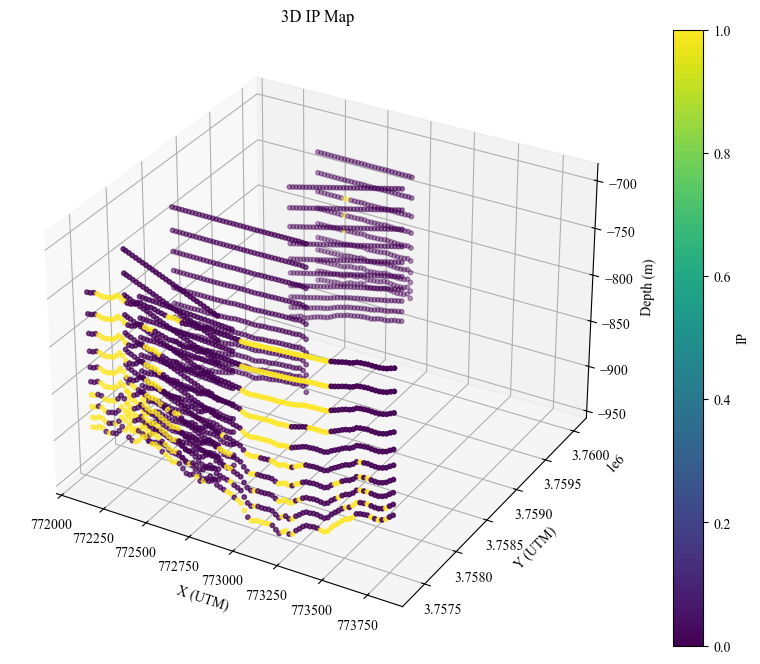

In [15]:

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates
X, Y, Z = data_ip["X"], data_ip["Y"], data_ip["Z"]

# Plot interpolated MAG values
sc = ax.scatter(X, Y, -Z, c=data_ip["Potential"], s=10)
ax.set_xlabel('X (UTM)')
ax.set_ylabel('Y (UTM)')
ax.set_zlabel('Depth (m)')
ax.set_title('3D IP Map')
fig.colorbar(sc, label='IP')
plt.savefig(f'D:/GeoPhy_2/IP/Scenario27/LocIPALL_Sc27_IP.png', dpi=600)

plt.show()


In [16]:
from tensorflow.keras.models import load_model
import tifffile as tiff #for read multi chanel img
import random
from collections import deque
import tensorflow as tf
from tensorflow import keras
#import cv2
import matplotlib.pyplot as plt
from collections import deque
#from PIL import Image
import numpy as np
import rasterio as rio
#from pyrsgis import ml
#import csv

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from pyproj import Transformer
import requests

import numpy as np
from shapely.geometry import Polygon, Point

from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go

from scipy.spatial import KDTree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [17]:

env_img = rio.open('D:/GeoPhy/point/second_local/S_LA_AS.tif')
array_env = env_img.read().astype('float32')  # shape: (16, H, W)

# Normalize each channel
for i in range(array_env.shape[0]):
    band = array_env[i]
    array_env[i] = (band - band.min()) / (band.max() - band.min())


In [18]:
# Load magnetic grid points
#data_mag = pd.read_csv('D:/GeoPhy_2/Mag/Data/mag_grid_intpol2.csv')
data_mag = pd.read_csv('D:/GeoPhy_2/Mag/Data/Area_grid2.csv')
#data_mag2 = pd.read_excel('D:/GeoPhy_2/Mag/Data/Finalmag.xls', sheet_name='Base')
#Normalize
data_mag["MAG"]=(data_mag["MAG"]-data_mag["MAG"].min())/(data_mag["MAG"].max()-data_mag["MAG"].min())
#data_mag2["MAG"]=(data_mag2["MAG"]-data_mag2["MAG"].min())/(data_mag2["MAG"].max()-data_mag2["MAG"].min())


In [19]:
def interpolate_mag_IDW(x, y, z, tree, data_mag, k=5):
    # Scale z to make it more influential in distance calculation
    query_point = [x, y, z ]

    # Scale z in the tree data as well (assumes tree was built with scaled z)
    dist, idx = tree.query(query_point, k=k)

    # Inverse IDW weighting
    weights = 1 / (dist + 1e-12)
    weights /= weights.sum()
    
# Interpolate the value
    interpolated_value = np.sum(data_mag.iloc[idx]['MAG'].values * weights)
  
    return interpolated_value


In [18]:
def interpolate_mag_knn_weighted_z(x, y, z, tree, data_mag, k=8, z_weight=1.0):
    # Scale z to make it more influential in distance calculation
    query_point = [x, y, z * z_weight]

    # Scale z in the tree data as well (assumes tree was built with scaled z)
    dist, idx = tree.query(query_point, k=k)

    # Inverse distance weighting
    weights = 1 / (dist + 1e-6)

    # Retrieve magnetic values
    mags = data_mag.iloc[idx]['MAG'].values

    # Weighted average
    return np.dot(weights, mags) / np.sum(weights)

In [42]:
datamag_clean= pd.DataFrame(columns=['X', 'Y', 'Z','MAG'])
for i in range(len(data_mag2)):
  #print(data_mag.iloc[i]["X"],data_mag.iloc[i]["Y"])
  if str(data_mag2.iloc[i]["Z"]).isnumeric() :
    datamag_clean.loc[len(datamag_clean.index)] = [data_mag2.iloc[i]["X"],data_mag2.iloc[i]["Y"],float(data_mag2.iloc[i]["Z"])
    ,data_mag2.iloc[i]["MAG"]]
data_mag2 = datamag_clean

In [25]:

coords = np.column_stack((data_mag['X'], data_mag['Y'], data_mag['Z']))
tree = KDTree(coords)

print(interpolate_mag_IDW(772951,3758194,897,tree,data_mag))
#print(interpolate_mag_knn_weighted_z(772951,3758194,897,tree,data_mag))

#coords2 = np.column_stack((data_mag2['X'], data_mag2['Y'], data_mag2['Z']))
#tree2 = KDTree(coords2)

#print(interpolate_mag_IDW(772951,3758194,897,tree2,data_mag2))

#tree=tree2

0.4075468308507575


In [27]:
def build_model(action_size):
    
    model = keras.Sequential([
        keras.Input(shape=(x_input, y_input, z_input, 18)),
        keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling3D((2, 2, 2)),

        keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling3D((2, 2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(action_size, activation='softmax')
     ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
    )
    return model

In [29]:
def utm_to_pixel(x, y):
    # Reverse x from right edge
    col = (x-772385) //15
    # Reverse y from top edge
    row = (3761793-y) //15
    return  row,col

In [31]:
x_input, y_input, z_input, canal = 8, 8, 8, 17
def extract_patch(x, y, Z_in, mag_in):
    r, b = x_input // 2, y_input // 2
    if (x < 772460 or x + r > 773947 or
        y - b > 3761793 or y + b < 3756250):
        return None

    x_pix, y_pix = map(int, utm_to_pixel(x, y))

    # Extract surface patch: shape (16, x, y)
    patch = array_env[:, x_pix - r:x_pix + r, y_pix - b:y_pix + b]
    patch = np.moveaxis(patch, 0, -1)  # shape: (x, y, 16)

    # Repeat surface patch across depth
    volume = np.repeat(patch[:, :, np.newaxis, :], z_input, axis=2)  # shape: (x, y, z, 16)

    # Create depth layer centered around Z_in
    z_range = np.linspace(Z_in - z_input // 2, Z_in + z_input // 2 - 1, z_input)
    z_layer = np.tile(z_range[np.newaxis, np.newaxis, :, np.newaxis], (x_input, y_input, 1, 1))  # shape: (x, y, z, 1)
# Compute MAG for each voxel
    mag_layer = np.zeros((x_input, y_input, z_input, 1), dtype='float32')
    for i in range(x_input):
        for j in range(y_input):
            for k in range(z_input):
                xi = x + i - r
                yj = y + j - b
                zk = z_range[k]
                mag_layer[i, j, k, 0] = interpolate_mag_IDW(xi, yj, zk, tree, data_mag)
                #mag_layer[i, j, k, 0] = interpolate_mag_knn_weighted_z(xi, yj, zk, tree, data_mag)
                

    # Concatenate all features
    volume = np.concatenate([volume, z_layer, mag_layer], axis=-1)  # (x, y, z, 18)

    return volume

In [108]:
data_ip#[data_ip["pname"] != "P5"][["X","Y","Z"]]


,Name,X,Y,Z,IP,Res,Potential
0,P1,772118.942,3757355.0,888.997,105.6500,65.4600,0
1,P1,772138.929,3757355.0,888.505,20.3150,45.7690,1
2,P1,772158.723,3757355.0,886.104,689.8700,42.8090,0
3,P1,772178.233,3757355.0,886.462,123.1100,42.3910,0
4,P1,772197.908,3757355.0,889.311,70.3000,126.7200,0
...,...,...,...,...,...,...,...
2544,P9,772885.132,3760036.0,732.940,2.1708,1.8286,0
2545,P9,772905.054,3760036.0,732.951,2.2692,1.8264,0
2546,P9,772924.991,3760036.0,732.949,2.3550,1.8272,0
2547,P9,772944.895,3760036.0,732.848,2.4178,1.8288,0


In [33]:
X=data_ip[["X","Y","Z"]]
Y=data_ip[["Potential"]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y,random_state=17)


#X_train=data_ip[data_ip["pname"] != "P5"][["X","Y","Z"]]
#y_train=data_ip[data_ip["pname"] != "P5"][["Potential"]]

#X_test=data_ip[data_ip["pname"] == "P5"][["X","Y","Z"]]
#y_test=data_ip[data_ip["pname"] == "P5"][["Potential"]]

print(y_train.shape,y_test.shape)
train_patches, train_labels = [], []
for i in range(len(X_train)):
    x, y_coord, z = X_train.iloc[i]["X"], X_train.iloc[i]["Y"], X_train.iloc[i]["Z"]

    mg=interpolate_mag_IDW(x,y_coord,z,tree,data_mag)
    #mg=interpolate_mag_knn_weighted_z(x,y_coord,z,tree,data_mag)
    
    patch = extract_patch(x, y_coord, z,mg)
    
    if patch is not None:
        train_patches.append(patch)
        train_labels.append(y_train.iloc[i])

X_train_array = np.array(train_patches)
y_train_array = np.array(train_labels)

test_patches, test_labels = [], []
for i in range(len(X_test)):
    x, y_coord, z = X_test.iloc[i]["X"], X_test.iloc[i]["Y"], X_test.iloc[i]["Z"]
    mg=interpolate_mag_IDW(x,y_coord,z,tree,data_mag)
    #mg=interpolate_mag_knn_weighted_z(x,y_coord,z,tree,data_mag)
    

    patch = extract_patch(x, y_coord, z,mg)
    if patch is not None:
        test_patches.append(patch)
        test_labels.append(y_test.iloc[i])

X_test_array = np.array(test_patches)
y_test_array = np.array(test_labels)
print(y_train_array.shape,y_test_array.shape)


(2039, 1) (510, 1)
(1505, 1) (376, 1)


In [34]:
def first_eva(y,pred):
    print("log_loss :",metrics.log_loss(y,pred))
    print("roc_auc_score :",metrics.roc_auc_score(y,pred))
    print("precision_score :",metrics.precision_score(y,pred))
    print("recall_score :",metrics.recall_score(y,pred))
    print("f1_score :",metrics.f1_score(y,pred))
    print("accuracy_score :",metrics.accuracy_score(y,pred))
    print("confusion_matrix :",metrics.confusion_matrix(y,pred))

In [35]:
print(y_train_array.shape,y_train_array[y_train_array==0].shape)

y_train_array = y_train_array.ravel()   
y_test_array = y_test_array.ravel()     

print(X_test_array.shape,y_test_array.shape)
print(X_train_array.shape,y_train_array.shape)

sed=8
# ثابت کردن seed پایتون
random.seed(sed)
# ثابت کردن seed numpy
np.random.seed(sed)
# ثابت کردن seed TensorFlow
tf.random.set_seed(sed)


(1505, 1) (1303,)
(376, 8, 8, 8, 18) (376,)
(1505, 8, 8, 8, 18) (1505,)


In [41]:
al=1505
zer=1303
for i in range(10):
    
    sed=random.randint(1,1000)
# ثابت کردن seed پایتون
    random.seed(sed)
# ثابت کردن seed numpy
    np.random.seed(sed)
# ثابت کردن seed TensorFlow
    tf.random.set_seed(sed)
    model_CNN=build_model(2)
    print(sed,i)
    class_weight = {0: (al/(zer*2)), 1: (al/((al-zer)*2))}#22-4 {0: 0.56, 1: 4.31}

    model_CNN.fit(X_train_array, y_train_array,
                                  epochs=300,
                                 #  validation_split=0.2,
                                   #class_weight=class_weight,
                                   #callbacks=[earlyStopping],
                                   batch_size=16,verbose=0)
    y_pred = model_CNN.predict(X_test_array)
    pred=np.argmax(y_pred, axis=1)
    first_eva(y_test_array,pred)
    print("train")

    y_pred = model_CNN.predict(X_train_array)
    y_pred=np.argmax(y_pred, axis=1)
    first_eva(y_train_array,y_pred)
    model_CNN.save("D:/GeoPhy_2/IP/Scenario27/Model"+str(i)+"_CNN16300.keras")
    


820 0
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
log_loss : 4.026152772188619
roc_auc_score : 0.7102290457467391
precision_score : 0.5897435897435898
recall_score : 0.46938775510204084
f1_score : 0.5227272727272727
accuracy_score : 0.8882978723404256
confusion_matrix : [[311  16]
 [ 26  23]]
train
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
log_loss : 2.418876406844407
roc_auc_score : 0.8232031184699438
precision_score : 0.7953216374269005
recall_score : 0.6732673267326733
f1_score : 0.7292225201072386
accuracy_score : 0.932890365448505
confusion_matrix : [[1268   35]
 [  66  136]]
1000 1
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
log_loss : 5.272342915961286
roc_auc_score : 0.681676340260875
precision_score : 0.44
recall_score : 0.4489795918367347
f1_score : 0.4444444444444444
accuracy_score : 0.8537234042553191
confusion_matrix : [[299  28]
 [ 27  22]]
train
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
log_loss : 5.7478251251748285
roc_auc_score : 0.6757463735629127
precision_score : 0.413636363636

In [42]:
model_CNN=build_model(2)

class_weight = {0: (1516/(1310*2)), 1: (1516/((1516-1310)*2))}#22-4 {0: 0.56, 1: 4.31}

model_CNN.fit(X_train_array, y_train_array,
                                  epochs=300,
                                 #  validation_split=0.2,
                                   #class_weight=class_weight,
                                   #callbacks=[earlyStopping],
                                   batch_size=16,verbose=0)
y_pred = model_CNN.predict(X_test_array)
pred=np.argmax(y_pred, axis=1)
first_eva(y_test_array,pred)
print("train")

y_pred = model_CNN.predict(X_train_array)
y_pred=np.argmax(y_pred, axis=1)
first_eva(y_train_array,y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
log_loss : 2.271243912190944
roc_auc_score : 0.9392049643647089
precision_score : 0.7101449275362319
recall_score : 0.9423076923076923
f1_score : 0.8099173553719008
accuracy_score : 0.936986301369863
confusion_matrix : [[293  20]
 [  3  49]]
train
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
log_loss : 2.425100689769096
roc_auc_score : 0.8956125398354703
precision_score : 0.7131147540983607
recall_score : 0.8446601941747572
f1_score : 0.7733333333333333
accuracy_score : 0.9327176781002638
confusion_matrix : [[1240   70]
 [  32  174]]


In [43]:
model_CNN.save("D:/GeoPhy_2/IP/Scenario26/Model_CNN16300.keras")

In [42]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=17)
# make flat data
n_samples = X_train_array.shape[0]
X_flat = X_train_array.reshape(n_samples, -1)  # shape: (n_samples, 8*8*8*17)

rf_model.fit(X_flat, y_train_array)

n_samples_te = X_test_array.shape[0]
y_pred = rf_model.predict(X_test_array.reshape(n_samples_te, -1))
first_eva(y_test_array,y_pred)

print("train")

n_samples = X_train_array.shape[0]
y_pred = rf_model.predict(X_train_array.reshape(n_samples, -1))
first_eva(y_train_array,y_pred)

log_loss : 1.7254940452236935
roc_auc_score : 0.8770517381264432
precision_score : 0.8444444444444444
recall_score : 0.7755102040816326
f1_score : 0.8085106382978723
accuracy_score : 0.9521276595744681
confusion_matrix : [[320   7]
 [ 11  38]]
train
log_loss : 2.2204460492503136e-16
roc_auc_score : 1.0
precision_score : 1.0
recall_score : 1.0
f1_score : 1.0
accuracy_score : 1.0
confusion_matrix : [[1303    0]
 [   0  202]]


In [43]:
import joblib

joblib.dump(rf_model, 'D:/GeoPhy_2/IP/Scenario27/RF_model.pkl')

['D:/GeoPhy_2/IP/Scenario27/RF_model.pkl']

In [47]:
n_samples = X_train_array.shape[0]
X_flat = X_train_array.reshape(n_samples, -1)  # shape: (n_samples, 8*8*8*17)

svm_model = SVC(kernel='linear', class_weight='balanced', cache_size=1000,probability=True, random_state=17)
svm_model.fit(X_flat, y_train_array)


n_samples_te = X_test_array.shape[0]
y_pred = svm_model.predict(X_test_array.reshape(n_samples_te, -1))
pred_svm=y_pred


n_samples_te = X_test_array.shape[0]
y_pred = svm_model.predict(X_test_array.reshape(n_samples_te, -1))
first_eva(y_test_array,pred)
print("train")

n_samples_te = X_train_array.shape[0]
y_pred = svm_model.predict(X_train_array.reshape(n_samples_te, -1))
first_eva(y_train_array,y_pred)

log_loss : 7.18955852176539
roc_auc_score : 0.7291705673094926
precision_score : 0.3522727272727273
recall_score : 0.6326530612244898
f1_score : 0.45255474452554745
accuracy_score : 0.800531914893617
confusion_matrix : [[270  57]
 [ 18  31]]
train
log_loss : 13.507389044160846
roc_auc_score : 0.7480205618412954
precision_score : 0.2527322404371585
recall_score : 0.9158415841584159
f1_score : 0.3961456102783726
accuracy_score : 0.6252491694352159
confusion_matrix : [[756 547]
 [ 17 185]]


In [56]:
n_samples_te = X_train_array.shape[0]
y_pred = svm_model.predict(X_train_array.reshape(n_samples_te, -1))
first_eva(y_train_array,y_pred)

log_loss : 13.507389044160846
roc_auc_score : 0.7480205618412954
precision_score : 0.2527322404371585
recall_score : 0.9158415841584159
f1_score : 0.3961456102783726
accuracy_score : 0.6252491694352159
confusion_matrix : [[756 547]
 [ 17 185]]


In [58]:
import joblib

joblib.dump(svm_model, 'D:/GeoPhy_2/IP/Scenario27/SVM_linear_model.pkl')

['D:/GeoPhy_2/IP/Scenario27/SVM_linear_model.pkl']

In [44]:
n_samples = X_train_array.shape[0]
X_flat = X_train_array.reshape(n_samples, -1)  # shape: (n_samples, 8*8*8*17)

#svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=17)

# Use SGDClassifier - stochastic gradient descent, much faster
from sklearn.linear_model import SGDClassifier
svm_model = SGDClassifier(loss='hinge',  # SVM equivalent
                          class_weight='balanced',
                          random_state=7,
                          max_iter=1000,
                          tol=1e-3,
                          n_jobs=-1)  # Parallel processing
svm_model.fit(X_flat, y_train_array)


n_samples_te = X_test_array.shape[0]
y_pred = svm_model.predict(X_test_array.reshape(n_samples_te, -1))
pred_svm=y_pred


n_samples_te = X_test_array.shape[0]
y_pred = svm_model.predict(X_test_array.reshape(n_samples_te, -1))
first_eva(y_test_array,y_pred)
print("train")

n_samples_te = X_train_array.shape[0]
y_pred = svm_model.predict(X_train_array.reshape(n_samples_te, -1))
first_eva(y_train_array,y_pred)

log_loss : 31.34647515489709
roc_auc_score : 0.5
precision_score : 0.13031914893617022
recall_score : 1.0
f1_score : 0.23058823529411765
accuracy_score : 0.13031914893617022
confusion_matrix : [[  0 327]
 [  0  49]]
train
log_loss : 31.205900575428334
roc_auc_score : 0.5
precision_score : 0.13421926910299004
recall_score : 1.0
f1_score : 0.23667252489748097
accuracy_score : 0.13421926910299004
confusion_matrix : [[   0 1303]
 [   0  202]]


In [46]:
joblib.dump(svm_model, 'D:/GeoPhy_2/IP/Scenario27/SVM_linear_model_sgd.pkl')

['D:/GeoPhy_2/IP/Scenario27/SVM_linear_model_sgd.pkl']

In [ ]:
def select_action(state):
    global epsilon
    if np.random.rand() <= epsilon:
        return random.randint(0, 1)  # Explore
    q_values = train_model.predict(np.expand_dims(state, axis=0), verbose=0)
    return np.argmax(q_values[0])  # Exploit


In [ ]:
def remember(state,action , rew):
  global memory
  memory.append((state,action,rew))

In [ ]:
x_input=8
y_input=8
z_input=8
canal=17
actions=2
train_model=build_model(actions)
memory=deque(maxlen=100000)

epsilon=1
epsilon_decay=0.9
epsilon_min=0.05

li_res=[]


sed=17
# ثابت کردن seed پایتون
random.seed(sed)
# ثابت کردن seed numpy
np.random.seed(sed)
# ثابت کردن seed TensorFlow
tf.random.set_seed(sed)

In [ ]:
def train(epirew, x_t, y_t):
    global memory, train_model ,epsilon

    if epirew>((1-epsilon)*100):
        li_selected=random.choices(memory, k=10)
    else :
        li_selected =memory #random.choices(memory, k=batch_size)
    
    Weigh = 0
    for state, action, reward in li_selected:
        # Ensure correct input shape
        state = state[..., :18]  # or :17 depending on your model
        x_t.append(state)

        # Use integer labels for sparse_categorical_crossentropy
        label = 1 if action > 0 else 0
        
        y_t.append(label)


    x_t = np.array(x_t, dtype=np.float32)
    y_t = np.array(y_t, dtype=np.int32)

    al = len(x_t)
    Weigh=y_t[y_t==1].shape[0]
    #print(Weigh)
    cls_weight = {0: al / ((al - Weigh) * 2), 1: al / (Weigh * 2)}
    #print(cls_weight)
    #print(al, Weigh)
    for i in range(300):
        train_model.train_on_batch(x_t, y_t,
                                  class_weight=cls_weight)  


In [ ]:
X=data_ip[["X","Y","Z"]]
Y=data_ip[["Potential"]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y,random_state=17)

train_patches, train_labels = [], []
for i in range(len(X_train)):
    x, y_coord, z = X_train.iloc[i]["X"], X_train.iloc[i]["Y"], X_train.iloc[i]["Z"]

    mg=interpolate_mag_IDW(x,y_coord,z,tree,data_mag)
    #mg=interpolate_mag_knn_weighted_z(x,y_coord,z,tree,data_mag)
    
    patch = extract_patch(x, y_coord, z,mg)
    if patch is not None:

        train_patches.append(patch)
        train_labels.append(y_train.iloc[i])

X_train_array = np.array(train_patches)
y_train_array = np.array(train_labels)

test_patches, test_labels = [], []
for i in range(len(X_test)):
    x, y_coord, z = X_test.iloc[i]["X"], X_test.iloc[i]["Y"], X_test.iloc[i]["Z"]
    mg=interpolate_mag_IDW(x,y_coord,z,tree,data_mag)
    #mg=interpolate_mag_knn_weighted_z(x,y_coord,z,tree,data_mag)
    

    patch = extract_patch(x, y_coord, z,mg)
    if patch is not None:
        test_patches.append(patch)
        test_labels.append(y_test.iloc[i])

X_test_array = np.array(test_patches)
y_test_array = np.array(test_labels)

In [ ]:
siz=len(X_train_array)-1
for epis in range(100):
  x_epi=[]
  y_epi=[]
  epi_rew=0
  for i in range(100):
      rand_data=random.randint(0,siz)
      state=X_train_array[rand_data]
      action = select_action(state)
      
      rew=0#act(state)
      act =y_train_array[rand_data]
      if act[0]==action :
          epi_rew+=1
          rew=1
      x_epi.append(state)
      #y_epi.append(act)
      label = 1 if action > 0 else 0
      y_epi.append(label)
      if rew>0:
          remember(state,action,rew)

  epsilon= (epsilon*epsilon_decay) if epsilon>epsilon_min else epsilon_min
  train(epi_rew,x_epi,y_epi)
  train_model.save("D:/GeoPhy_2/IP/Scenario25/DQL/sec"+str(epis)+".keras")
  
  y_pred = train_model.predict(X_test_array)
  pred=np.argmax(y_pred, axis=1)
  print("eisode "+str(epis)+" reward :"+str(epi_rew))
  li_res.append(epi_rew)
  print("accuracy_score :"+str(epis),metrics.accuracy_score(y_test_array,pred))
  print("confusion_matrix :"+str(epis),metrics.confusion_matrix(y_test_array,pred))
  print("Train")
    
  y_pred = train_model.predict(X_train_array)
  pred=np.argmax(y_pred, axis=1)
  print("accuracy_score :"+str(epis),metrics.accuracy_score(y_train_array,pred))
  print("confusion_matrix :"+str(epis),metrics.confusion_matrix(y_train_array,pred))
  